<a href="https://colab.research.google.com/github/myidispg/PytorchProjects/blob/master/Private%20AI/differential_privacy_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load the MNIST Dataset using Torchvision

In [22]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize((0.5,), (0.5,))])

mnist_trainset = torchvision.datasets.MNIST(root='./MNIST_data/', train=True, download=True, transform=transforms)
mnist_testset = torchvision.datasets.MNIST(root='./MNIST_data/', train=False, download=True, transform=transforms)
print(f'Trainset length: {len(mnist_trainset)}')
print(f'Testset: {len(mnist_testset)}')
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=True)

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Trainset length: 60000
Testset: 10000


Plotting 10 random images from the train set and their corresponding labels...


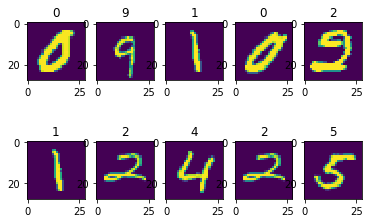

In [24]:
# To unnormalize the image and put channel after the image height and width.
def im_show_process(img):
  img = (img / 2) + 0.5 # Unnormalize the image
  img = img.numpy()
  
  # Since, PyTorch needs channels before the height and width and
  # matplotlib needs channels afterwards, transpose them to make images compatible.
  return np.transpose(img, (1, 2, 0)).reshape(img.shape[1], -1)

print(f'Plotting 10 random images from the train set and their corresponding labels...')
dataiter = iter(trainloader)
images, labels = dataiter.next()

f, axarr = plt.subplots(2, 5)

for i in range(2):
  for j in range(5):
    index = np.random.randint(0, 64)
    image = im_show_process(images[index])
#     image = images[index]
    axarr[i, j].imshow(image)
    axarr[i, j].set_title(classes[labels[index]])

In [0]:
print(f'Plotting 10 random images from the test set and their corresponding labels...')
dataiter = iter(testloader)
images, labels = dataiter.next()

f, axarr = plt.subplots(2, 5)

for i in range(2):
  for j in range(5):
    index = np.random.randint(0, 64)
    axarr[i, j].imshow(im_show_process(images[index]))
    axarr[i, j].set_title(classes[labels[index]])

## Building the model

In [62]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
  
  def __init__(self):
    super(Model, self).__init__()
    
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)
    
  def forward(self, X):
    X = X.view(X.shape[0], -1)
#     print(X.shape)
    
    hidden = F.relu(self.fc1(X))
    hidden = F.relu(self.fc2(hidden))
    
    return self.fc3(hidden)
  
model = Model()
image = torch.randn((64, 28, 28, 1))
print(f"Image's shape before inputting: {image.shape}")
image = model(image)
print(f'Output image shape: {image.shape}')

Image's shape before inputting: torch.Size([64, 28, 28, 1])
Output image shape: torch.Size([64, 10])


##Defining some parameters and criterion, optimizer

In [0]:
epsilon = 3.01
beta = 1/epsilon
lr = 0.15
epochs = 60
train_loss = []
validation_loss = []
validation_acc = []

running_loss = 0

model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

###Training the model

In [87]:
for epoch in range(epochs):

  for inputs, labels in trainloader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()

    logps = model(inputs)
    loss = criterion(logps, labels)
    loss.backward()

        # Perform gradient clipping in l2 norm
    nn.utils.clip_grad_norm_(model.parameters(), 4)
    
    for params in model.parameters():
      noise = torch.from_numpy(np.random.laplace(0, beta, params.shape)).float().to(device)
      params.grad += 1.1 * noise
    
    optimizer.step()
    running_loss += loss.item()
  
  else:
    test_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
      for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model(inputs)
        batch_loss = criterion(logps, labels)
        
        test_loss += batch_loss.item()
         
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
          
      print(f"Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {running_loss/len(trainloader):.8f}.. "
            f"Test loss: {test_loss/len(testloader):.8f}.. "
            f"Test accuracy: {accuracy/len(testloader):.8f}")
      train_loss.append(running_loss/len(trainloader))
      validation_loss.append(test_loss/len(testloader))
      validation_acc.append(accuracy/(len(testloader)))
      running_loss = 0
      model.train()

Epoch 1/60.. Train loss: 4.26179396.. Test loss: 3.55824878.. Test accuracy: 0.09613854
Epoch 2/60.. Train loss: 6.96881191.. Test loss: 6.45092087.. Test accuracy: 0.09743232
Epoch 3/60.. Train loss: 10.10820153.. Test loss: 11.67387411.. Test accuracy: 0.10290605
Epoch 4/60.. Train loss: 12.21021783.. Test loss: 6.21905735.. Test accuracy: 0.09026672
Epoch 5/60.. Train loss: 15.26703528.. Test loss: 14.16736023.. Test accuracy: 0.09713376
Epoch 6/60.. Train loss: 14.71781755.. Test loss: 22.90760380.. Test accuracy: 0.09743232
Epoch 7/60.. Train loss: 24.21731225.. Test loss: 12.87559924.. Test accuracy: 0.09773089
Epoch 8/60.. Train loss: 22.09361542.. Test loss: 73.00851338.. Test accuracy: 0.09892516
Epoch 9/60.. Train loss: 22.64652497.. Test loss: 18.14347968.. Test accuracy: 0.10131369
Epoch 10/60.. Train loss: 21.55443799.. Test loss: 21.35104728.. Test accuracy: 0.10121417
Epoch 11/60.. Train loss: 41.96173218.. Test loss: 60.71806279.. Test accuracy: 0.09723328
Epoch 12/60..

Text(0.5, 1.0, 'Training Losses')

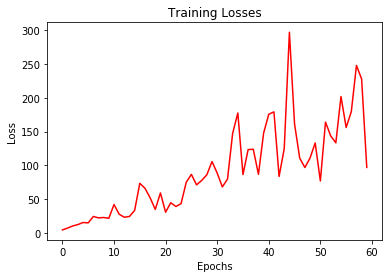

In [88]:
# Plot the training losses.
plt.plot(train_loss, color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')

Text(0.5, 1.0, 'Validation Losses')

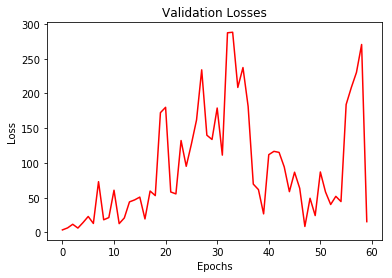

In [89]:
# Plot Validation losses

plt.plot(validation_loss, color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Losses')

Text(0.5, 1.0, 'Validation Accuracy')

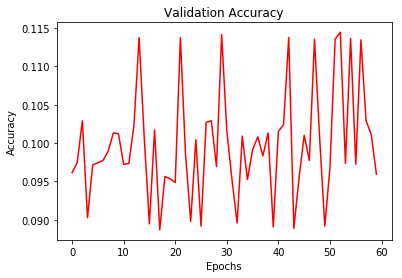

In [90]:
# Plot the validation accuracy
plt.plot(validation_acc, color='r')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')